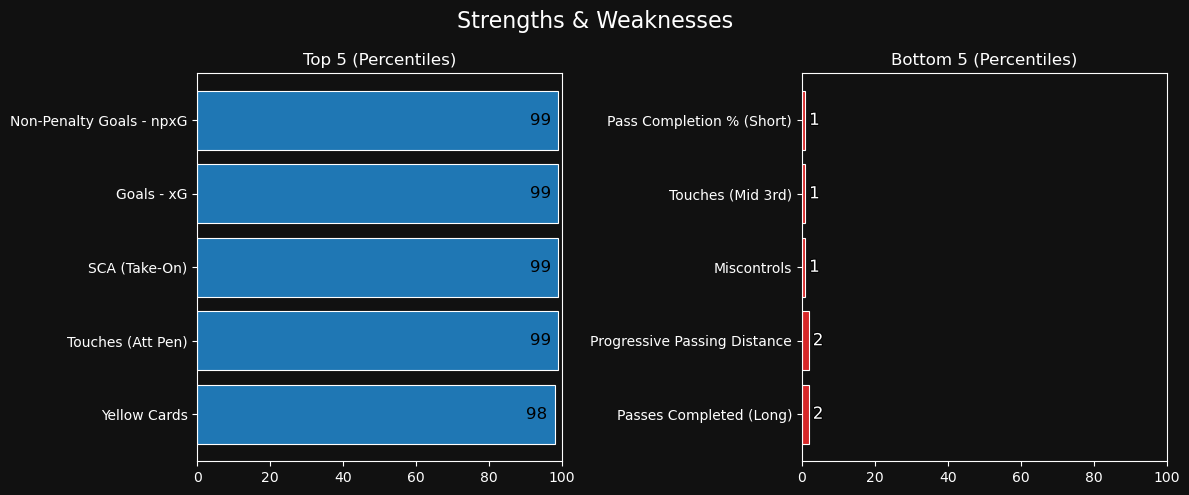

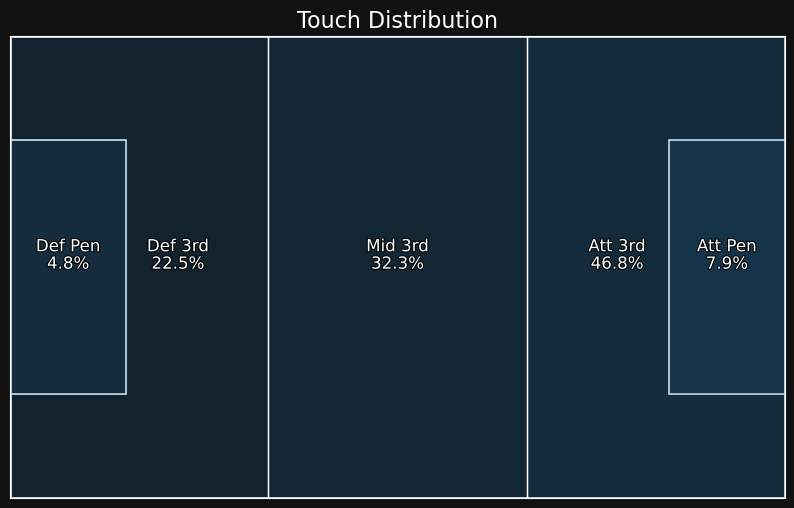

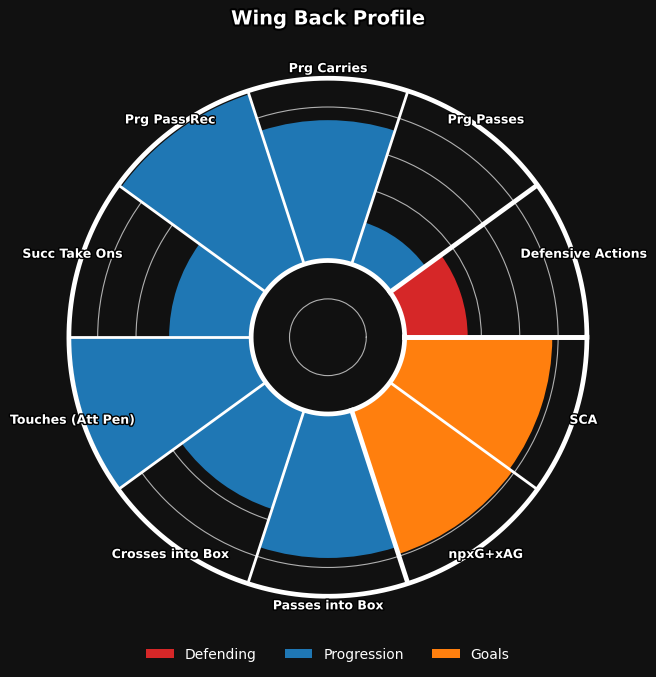

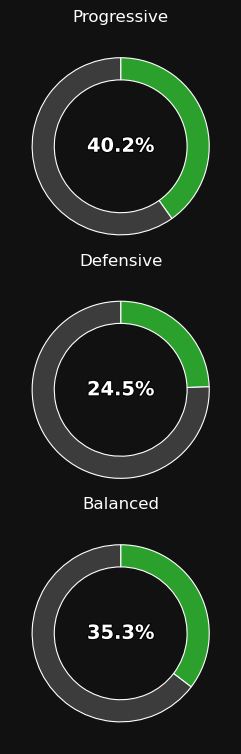

In [1]:
#SETTINGS
WORKBOOK   = "Rodrigo-Gomes.xlsx"
SHOW_FIGS  = True

import pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from openpyxl import load_workbook
from pathlib import Path
import re, unicodedata

FIG_BG = AX_BG = "#111111"
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.4

TILE_BG   = "#1d1d1d"
TILE_EDGE = "#2b2b2b"
TILE_TEXT = "white"
TILE_VALUE = "white"

DEF_COLOR   = "#d62728"
PROG_COLOR  = "#1f77b4"
GOAL_COLOR  = "#ff7f0e"
PASS_COLOR  = "#2ca02c"

TITLE_FONTSIZE = 16
LABEL_FONTSIZE = 10
VALUE_FONTSIZE = 12

mpl.rcParams.update({
    "figure.facecolor": FIG_BG,
    "axes.facecolor": AX_BG,
    "savefig.facecolor": FIG_BG,
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
})

def stroke_txt(txt, lw=1.5):
    return [path_effects.Stroke(linewidth=lw, foreground="black"), path_effects.Normal()]

def clean_axis(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

def seed_sheet1_indirect_formulas(workbook_path, player_sheet_hint=None):
    wb = load_workbook(workbook_path)
    sheets = wb.sheetnames
    if not player_sheet_hint:
        for s in sheets:
            if s != "Sheet 1":
                player_sheet_hint = s
                break
    wb.save(workbook_path)
    raw = pd.read_excel(workbook_path, sheet_name=player_sheet_hint, header=None)
    raw.columns = ["Metric","Per90","Percentile"]
    metric_to_row = {}
    for i, r in raw.iterrows():
        m = str(r["Metric"]).strip()
        if m and m != "nan":
            metric_to_row[m] = i + 1
    from openpyxl import load_workbook as lw
    wb2 = lw(workbook_path)
    if "Sheet 1" not in wb2.sheetnames:
        ws = wb2.create_sheet("Sheet 1", 0)
    else:
        ws = wb2["Sheet 1"]
        for row in ws["A1:Z2000"]:
            for cell in row:
                cell.value = None
    ws["A1"].value = "Player Sheet Name"
    ws["A2"].value = player_sheet_hint
    ws["A4"].value = "Stat"; ws["B4"].value = "Per90"; ws["C4"].value = "Percentile"
    sheet1_fields = [
        "Goals","Assists","Non-Penalty Goals","Penalty Kicks Made",
        "xG: Expected Goals","npxG: Non-Penalty xG","xAG: Exp. Assisted Goals","npxG + xAG",
        "Shots Total","Shots on target","Shot-creating Actions","Goal-creating Actions",
        "Crosses","Crosses into Penalty Area","Passes into Penalty Area",
        "Progressive Carries","Carries","Take-Ons Attempted","Successful Take-Ons",
        "Progressive Passes","Progressive Passes Received","Passes Received",
        "Passes Completed","Passes Attempted","Pass Completion %",
        "Passes Completed (Short)","Passes Attempted (Short)","Pass Completion % (Short)",
        "Passes Completed (Medium)","Passes Attempted (Medium)","Pass Completion % (Medium)",
        "Passes Completed (Long)","Passes Attempted (Long)","Pass Completion % (Long)",
        "Tackles","Tackles Won","Interceptions","Blocks","Clearances","Errors",
        "Aerials Won","Aerials Lost","% of Aerials Won",
        "Touches","Touches (Def Pen)","Touches (Def 3rd)","Touches (Mid 3rd)",
        "Touches (Att 3rd)","Touches (Att Pen)","Touches (Live-Ball)",
        "Progressive Passing Distance","Total Passing Distance"
    ]
    r = 5
    for field in sheet1_fields:
        ws[f"A{r}"].value = field
        rn = metric_to_row.get(field)
        if rn is not None:
            per90_formula = '''=IFERROR(@INDIRECT("'" & SUBSTITUTE($A$2,"'","''") & "'!B{row}"), "")'''.format(row=rn)
            pct_formula   = '''=IFERROR(@INDIRECT("'" & SUBSTITUTE($A$2,"'","''") & "'!C{row}"), "")'''.format(row=rn)
            ws[f"B{r}"].value = per90_formula
            ws[f"C{r}"].value = pct_formula
        r += 1
    wb2.save(workbook_path)

wb = load_workbook(WORKBOOK, data_only=True)
ws = wb["Sheet 1"] if "Sheet 1" in wb.sheetnames else None
if ws is None:
    raise RuntimeError("Sheet 1 not found. Run seed_sheet1_indirect_formulas(WORKBOOK) once.")

PLAYER_SHEET = ws["A2"].value if ws["A2"].value else "Player"
df = pd.read_excel(WORKBOOK, sheet_name="Sheet 1").rename(columns=lambda c: str(c).strip())
per90 = dict(zip(df.get("Stat",[]), df.get("Per90",[])))
pct   = dict(zip(df.get("Stat",[]), df.get("Percentile",[])))

if len([v for v in pct.values() if pd.notna(v)]) < 10:
    raw = pd.read_excel(WORKBOOK, sheet_name=PLAYER_SHEET, header=None)
    raw.columns = ["Metric","Per90","Percentile"]
    per90 = {}; pct = {}
    for _, r in raw.iterrows():
        m = str(r["Metric"]).strip()
        if not m or m == "nan": continue
        try: per90[m] = float(r["Per90"])
        except: pass
        try: pct[m] = float(r["Percentile"])
        except: pass

player_name = PLAYER_SHEET

clean_rows = [(k, v) for k, v in pct.items() if pd.notna(v)]
clean = pd.DataFrame(clean_rows, columns=["Stat","Percentile"])
top5 = clean.sort_values("Percentile", ascending=False).head(5)
bot5 = clean.sort_values("Percentile", ascending=True).head(5)

fig = plt.figure(figsize=(12,5)); fig.patch.set_facecolor(FIG_BG)
plt.suptitle(f"Strengths & Weaknesses", fontsize=16, y=0.98)
ax1 = fig.add_subplot(1,2,1); ax1.set_facecolor(AX_BG)
ax1.barh(top5["Stat"], top5["Percentile"], color=PROG_COLOR, edgecolor="white", linewidth=0.8)
ax1.set_xlim(0,100); ax1.invert_yaxis(); ax1.set_title("Top 5 (Percentiles)")
for y, v in enumerate(top5["Percentile"].astype(float).values):
    if np.isnan(v): 
        continue
    if v >= 8:
        ax1.text(v - 2, y, f"{v:.0f}", va="center", ha="right", fontsize=12, color="black", zorder=3)
    else:
        ax1.text(v + 1, y, f"{v:.0f}", va="center", ha="left", fontsize=12, color="white", path_effects=stroke_txt("x"), zorder=3)
ax2 = fig.add_subplot(1,2,2); ax2.set_facecolor(AX_BG)
ax2.barh(bot5["Stat"], bot5["Percentile"], color=DEF_COLOR, edgecolor="white", linewidth=0.8)
ax2.set_xlim(0,100); ax2.invert_yaxis(); ax2.set_title("Bottom 5 (Percentiles)")
for y, v in enumerate(bot5["Percentile"]):
    ax2.text(v+1, y, f"{v:.0f}", va="center", fontsize=12, path_effects=stroke_txt("x"))
plt.tight_layout()
if SHOW_FIGS: plt.show()

def g(name, d, default=np.nan):
    v = d.get(name, default)
    try: return float(v)
    except: return default

tot = g("Touches", per90, np.nan)
zones = [("Def Pen", g("Touches (Def Pen)", per90)),
         ("Def 3rd", g("Touches (Def 3rd)", per90)),
         ("Mid 3rd", g("Touches (Mid 3rd)", per90)),
         ("Att 3rd", g("Touches (Att 3rd)", per90)),
         ("Att Pen", g("Touches (Att Pen)", per90))]
shares = [ (0.0 if (pd.isna(tot) or tot==0 or pd.isna(v)) else v/tot) for _, v in zones ]

fig = plt.figure(figsize=(10,6)); ax = fig.add_subplot(111); ax.set_facecolor(AX_BG)
ax.add_patch(Rectangle((0,0), 120, 80, fill=False, ec="white", lw=2.0))
ax.plot([40,40],[0,80], color="white", lw=1.0); ax.plot([80,80],[0,80], color="white", lw=1.0)
ax.add_patch(Rectangle((0,18), 18, 44, fill=False, ec="white", lw=1.2))
ax.add_patch(Rectangle((102,18), 18, 44, fill=False, ec="white", lw=1.2))
fills = [ ((0,18,18,44), shares[0], "Def Pen"),
          ((0,0,40,80), shares[1], "Def 3rd"),
          ((40,0,40,80), shares[2], "Mid 3rd"),
          ((80,0,40,80), shares[3], "Att 3rd"),
          ((102,18,18,44), shares[4], "Att Pen") ]
for (x, y, w, h), s, lab in fills:
    alpha = 0.10 + 0.35 * (s)
    ax.add_patch(Rectangle((x, y), w, h, fc=PROG_COLOR, ec="white", lw=1.0, alpha=alpha))
    frac_x = 0.50; frac_y = 0.50
    if lab == "Def 3rd": frac_x = 0.65
    elif lab == "Att 3rd": frac_x = 0.35
    cy = y + h * frac_y + 2.0
    cx = x + w * frac_x
    ax.text(cx, cy, f"{lab}\n{s*100:.1f}%", ha="center", va="center", fontsize=12, path_effects=stroke_txt("x"))
ax.set_xlim(0,120); ax.set_ylim(0,80); ax.set_xticks([]); ax.set_yticks([])
ax.set_title(f"Touch Distribution", fontsize=16)
if SHOW_FIGS: plt.show()

def _norm(s):
    if s is None: return ""
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("—","-").replace("–","-").replace("−","-")
    s = s.lower()
    return re.sub(r"[^a-z0-9]+", "", s)

pct_norm_map = {}
for k, v in pct.items():
    nk = _norm(k)
    if nk not in pct_norm_map or pd.isna(pct_norm_map[nk][1]):
        pct_norm_map[nk] = (k, v)

def get_pct_exact(name):
    nk = _norm(name)
    if nk in pct_norm_map and pd.notna(pct_norm_map[nk][1]):
        try:
            return float(pct_norm_map[nk][1]) / 100.0
        except:
            return 0.0
    return 0.0

def get_pct_any(cands):
    for c in cands:
        v = get_pct_exact(c)
        if v > 0:
            return v
    return 0.0

def avg_of_metrics(metric_names):
    vals = []
    for m in metric_names:
        v = get_pct_exact(m)
        if v > 0:
            vals.append(v)
    if not vals:
        return 0.0
    return float(np.mean(vals))

def sca_pct():
    v = get_pct_any(["Shot-creating Actions","Shot Creating Actions","SCA"])
    if v > 0: return v
    comps = []
    for k, v in pct.items():
        if pd.isna(v): continue
        ks = str(k)
        if ks.startswith("SCA (") or ks.startswith("Shot-creating Actions (") or ks.startswith("Shot Creating Actions ("):
            try: comps.append(float(v))
            except: pass
    if comps:
        return float(np.mean(comps)) / 100.0
    return 0.0

defensive_components = ["Tackles","Interceptions","Blocks","Recoveries","Clearances","% of Aerials Won"]
defensive_actions = avg_of_metrics(defensive_components)

recv_prog = get_pct_any(["Progressive Passes Rec","Prog Passes Received","Passes Received"])
takeons   = get_pct_any(["Successful Take-Ons","Take-Ons Won","Dribbles Completed","Successful Dribbles"])
touch_att_pen = get_pct_any(["Touches (Att Pen)","Touches (Att Pen.)","Touches (Att Penalty Area)"])
cross_pen = get_pct_any(["Crosses into Penalty Area","Crosses Into Penalty Area"])
pass_pen  = get_pct_any(["Passes into Penalty Area","Passes Into Penalty Area"])
prog_pass = get_pct_any(["Progressive Passes"])
prog_carr = get_pct_any(["Progressive Carries"])

progression_items = [
    ("Prg Passes",  prog_pass),
    ("Prg Carries", prog_carr),
    ("Prg Pass Rec",recv_prog),
    ("Succ Take Ons",takeons),
    ("Touches (Att Pen)",touch_att_pen),
    ("Crosses into Box", cross_pen),
    ("Passes into Box",  pass_pen),
]

goals_items = [
    ("npxG+xAG", get_pct_any(["npxG + xAG","npxG+xAG"])),
    ("SCA",      sca_pct())
]

labels_vals = []
labels_vals.append(("Defensive Actions", defensive_actions))
for lab, v in progression_items:
    labels_vals.append((lab, v))
for lab, v in goals_items:
    labels_vals.append((lab, v))

vals = np.array([max(0.0, float(v)) for _, v in labels_vals])
VIS_MIN = 0.07
FLOOR_ZEROES = False
vals_plot = np.where(vals > 0, np.maximum(vals, VIS_MIN), 0.0)

labels = [lab for lab, _ in labels_vals]
n = len(labels)
angles = np.linspace(0, 2*np.pi, n, endpoint=False)
width  = 2*np.pi / n
theta_circle = np.linspace(0, 2*np.pi, 720)

inner_radius  = 0.35
outer_radius  = inner_radius + 1.0
inner_overlay = inner_radius + 0.05
scale = outer_radius - inner_overlay

idx_def_end  = 1
idx_prog_end = 1 + len(progression_items)
bounds = [0, idx_def_end, idx_prog_end]

def color_for_idx(i):
    if i < idx_def_end: return DEF_COLOR
    if i < idx_prog_end: return PROG_COLOR
    return GOAL_COLOR

wedge_colors = [color_for_idx(i) for i in range(n)]

fig = plt.figure(figsize=(7.4,7.4)); fig.patch.set_facecolor(FIG_BG)
ax  = plt.subplot(111, polar=True); ax.set_facecolor(AX_BG); ax.set_ylim(0, outer_radius)

ax.bar(angles, vals_plot * scale, width=width, bottom=inner_overlay, align="edge",
       color=wedge_colors, zorder=2)
for ang in angles:
    ax.plot([ang, ang], [inner_overlay, outer_radius], linewidth=SEP_THIN, color=SEPARATOR_COLOR, zorder=3)
for b_idx in bounds + [n]:
    ang = angles[b_idx % n]
    ax.plot([ang, ang], [inner_overlay, outer_radius], linewidth=SEP_THICK, color=SEPARATOR_COLOR, zorder=4)
ax.plot(theta_circle, np.full_like(theta_circle, outer_radius), color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=5, clip_on=False)
ax.plot(theta_circle, np.full_like(theta_circle, inner_overlay), color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=10, clip_on=False)

for ang, lab in zip(angles + width/2, labels):
    t = ax.text(ang, inner_radius + 1.05, lab, ha="center", va="center",
                fontsize=9, fontweight="bold", color="white", zorder=6)
    t.set_path_effects([path_effects.Stroke(linewidth=2, foreground="black"), path_effects.Normal()])

title = ax.set_title(f"Wing Back Profile", va="bottom", y=1.08, fontsize=14, fontweight="bold", color="white")
title.set_path_effects([path_effects.Stroke(linewidth=3, foreground="black"), path_effects.Normal()])

legend_handles = [
    Patch(facecolor=DEF_COLOR, label="Defending"),
    Patch(facecolor=PROG_COLOR, label="Progression"),
    Patch(facecolor=GOAL_COLOR, label="Goals")
]
leg = ax.legend(handles=legend_handles, loc="lower center", bbox_to_anchor=(0.5, -0.15),
                ncol=3, frameon=True)
plt.setp(leg.get_texts(), color="white")
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])
plt.subplots_adjust(bottom=0.18)
if SHOW_FIGS: plt.show()

def pget_pct(m):
    v = pct.get(m, np.nan)
    return 0.0 if pd.isna(v) else float(v)

prog_keys = ["Progressive Passes","Progressive Carries","Progressive Passes Received","Successful Take-Ons","Touches (Att Pen)","Crosses into Penalty Area","Passes into Penalty Area"]
def_keys  = defensive_components

prog_vals = []
for k in prog_keys:
    if k == "Progressive Passes Received":
        v = get_pct_any(["Progressive Passes Received","Prog Passes Received","Passes Received"])
        prog_vals.append(v*100.0 if v>0 else 0.0)
    elif k == "Successful Take-Ons":
        v = get_pct_any(["Successful Take-Ons","Take-Ons Won","Dribbles Completed","Successful Dribbles"])
        prog_vals.append(v*100.0 if v>0 else 0.0)
    elif k == "Touches (Att Pen)":
        v = get_pct_any(["Touches (Att Pen)","Touches (Att Pen.)","Touches (Att Penalty Area)"])
        prog_vals.append(v*100.0 if v>0 else 0.0)
    else:
        prog_vals.append(pget_pct(k))
def_vals  = []
for k in def_keys:
    if k == "% of Aerials Won":
        def_vals.append(pget_pct("% of Aerials Won"))
    else:
        def_vals.append(pget_pct(k))

prog_score = np.mean([v for v in prog_vals if v>0]) if any(v>0 for v in prog_vals) else 0.0
def_score  = np.mean([v for v in def_vals if v>0])  if any(v>0 for v in def_vals)  else 0.0
base_balance = 50.0
scores = np.clip(np.array([prog_score, def_score, base_balance]), 0, 100)
pct_scores = 100.0 * scores / scores.sum() if scores.sum() > 0 else np.array([33.3, 33.3, 33.3])

pt_labels = ["Progressive", "Defensive", "Balanced"]
pt_vals   = pct_scores.tolist()
GREEN = PASS_COLOR
GREY  = "#3c3c3c"

fig, axs = plt.subplots(3, 1, figsize=(4.6, 9.2), subplot_kw=dict(aspect="equal"), gridspec_kw={"hspace": 0.10})
fig.patch.set_facecolor(FIG_BG)
for ax, lab, val in zip(axs, pt_labels, pt_vals):
    ax.set_facecolor(AX_BG)
    sizes = [float(val), max(0.0, 100.0 - float(val))]
    ax.pie(
        sizes, startangle=90, counterclock=False,
        colors=[GREEN, GREY],
        wedgeprops=dict(width=0.25, edgecolor="white", linewidth=0.8),
    )
    ax.text(0, 0, f"{val:.1f}%", ha="center", va="center",
            fontsize=14, fontweight="bold", color="white", path_effects=stroke_txt("x"))
    ax.set_title(lab, fontsize=12, color="white", pad=10)
if SHOW_FIGS: plt.show()
